**Nhật ký ngày 15/6/2024:** Ước gì làm xong luận văn rồi nghỉ khỏe hehe

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import re
import warnings
import string
import emoji

# Ignore all future warnings
warnings.simplefilter(action='ignore')

# Importing dataset

Focus only on some national majority in English

In [66]:
english_major = pd.read_csv('database/english_major.csv')
english_major.shape

(43226, 25)

In [67]:
english_major.language.value_counts()

language
en    42284
vi      942
Name: count, dtype: int64

In [68]:
def map_score_to_sentiment(score):
    if score >= 0 and score < 5:
        return -1
    elif score >= 5 and score < 7:
        return 0
    else:
        return 1

# Apply the function to create a new 'sentiments' column
english_major['sentiments'] = english_major['score'].apply(map_score_to_sentiment)

In [69]:
english_major[english_major.language == 'en']['sentiments'].value_counts()

sentiments
 1    34616
 0     5123
-1     2545
Name: count, dtype: int64

In [70]:
sample = english_major[english_major.language == 'vi'].comment.tolist()

In [71]:
sentiments = english_major[english_major.language == 'vi'].sentiments.tolist()
# sample_score

# BERTopic

In [72]:
from pyvi import ViTokenizer
from sentence_transformers import SentenceTransformer

# Initialize the Sentence-BERT model
encoder = SentenceTransformer('distiluse-base-multilingual-cased-v1')
encoder.max_seq_length = 512

## Word Segmentation

In [11]:
# pip install spacy

In [73]:
from pyvi import ViTokenizer
import spacy

nlp = spacy.load('en_core_web_sm')
def word_segmentation(text,language):
    if language == 'vi':
        return ViTokenizer.tokenize(text)
    elif language == 'en':
        doc = nlp(text)
        return " ".join([token.text for token in doc])
    else:
        return text

segmented_sample = [word_segmentation(each,'vi') for each in sample]
# len(segmented_sample)

In [74]:
documents = sample

# Consider only noun and adj

In [15]:
# from pyvi import ViTokenizer, ViPosTagger

# # Function to filter only nouns and adjectives
# def filter_nouns_adjs(doc):
#     tokens = ViTokenizer.tokenize(doc)
#     words, pos_tags = ViPosTagger.postagging(tokens)
#     filtered_tokens = [word for word, pos in zip(words, pos_tags) if pos in ['N', 'A']]
#     return ' '.join(filtered_tokens)

# # Apply the function to all documents
# filtered_documents = [filter_nouns_adjs(doc) for doc in documents]

# # Print filtered documents
# # print(filtered_documents)


## Embeddings

In [75]:
# Encode the segmented text using SBERT
corpus_embeddings = encoder.encode(sample, show_progress_bar=True)

# corpus_embeddings = encoder.encode(filtered_documents, show_progress_bar=True)

# Check the length of the corpus embeddings
print(len(corpus_embeddings))

Batches:   0%|          | 0/30 [00:00<?, ?it/s]

942


In [76]:
import csv

def save_corpus_embedding(corpus_embedding, file_name):
    # Ensure the corpus_embedding is in the correct format
    if isinstance(corpus_embedding, list):
        if not all(isinstance(i, list) for i in corpus_embedding):
            raise ValueError("Each element in the corpus_embedding list should be a list.")
    elif isinstance(corpus_embedding, np.ndarray):
        corpus_embedding = corpus_embedding.tolist()
    else:
        raise ValueError("Corpus embedding should be a list of lists or a numpy array.")

    # Open the file with write mode
    with open(file_name, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write each embedding as a row in the CSV file
        for embedding in corpus_embedding:
            writer.writerow(embedding)

# Example usage:
# corpus_embedding = [[0.1, 0.2, 0.3], [0.4, 0.5, 0.6]]
# save_corpus_embedding(corpus_embeddings, 'corpus_embedding.csv')

In [77]:
save_corpus_embedding(corpus_embeddings, 'embeddings/english_major_vi_corpus_embedding.csv')

In [78]:
def load_corpus_embedding(file_name):
    corpus_embedding = []

    # Open the file with read mode
    with open(file_name, mode='r') as file:
        reader = csv.reader(file)
        
        # Read each row and convert to a list of floats
        for row in reader:
            corpus_embedding.append([float(value) for value in row])
    
    return corpus_embedding

In [79]:
corpus_embeddings = load_corpus_embedding('embeddings/english_major_vi_corpus_embedding.csv')

## Adding Sentiments

In [80]:
# Combine embeddings with sentiment scores

enhanced_embeddings = np.hstack((corpus_embeddings, np.array(sentiments).reshape(-1, 1)))
print(f"Embeddings shape: {enhanced_embeddings.shape}")

Embeddings shape: (942, 513)


## UMAP

In [81]:
from umap import UMAP

umap_model=UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
umap_model

UMAP(metric='cosine', min_dist=0.0, n_components=5, random_state=42)

In [142]:
from hdbscan import HDBSCAN

hdbscan_model=HDBSCAN(min_cluster_size=80, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
hdbscan_model

HDBSCAN(min_cluster_size=80, prediction_data=True)

In [143]:
from stopwordsiso import stopwords
stop_word_vi = stopwords('vi')
stop_word_en = stopwords('en')


In [144]:
# list(stop_word_vi)

In [145]:
from sklearn.feature_extraction.text import CountVectorizer


vectorizer_model=CountVectorizer(stop_words=list(stop_word_en), min_df=2, ngram_range=(1,2))
# vectorizer_model=CountVectorizer(stop_words=list(stop_word_vi), min_df=2, ngram_range=(1,2))

vectorizer_model

CountVectorizer(min_df=2, ngram_range=(1, 2),
                stop_words=['yours', 'how', 'therein', 'come', 'af', 'rw',
                            "how'll", 'evenly', 'vc', "it'd", 'ableabout',
                            'see', 'whim', 'numbers', 'together', 'hardly',
                            'beings', 'upon', 'below', 'za', 'possibly', 'all',
                            'going', "how's", 'shouldn', 'h', 'org', 'nr',
                            'really', 'within', ...])

In [146]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech

keybert_model=KeyBERTInspired()
pos_model=PartOfSpeech('en_core_web_sm')
mmr_model=MaximalMarginalRelevance(diversity=0.3)

representation_model={
    'KeyBERT':keybert_model,
    'MMR':mmr_model,
    'POS':pos_model
}

# Training 

In [147]:
seed_topics = {
    "service": ["dịch vụ",'lễ tân', "nhân viên", "phục vụ", "hỗ trợ", "thân thiện", "chuyên nghiệp", "chăm sóc", "giúp đỡ"],
    "location": ["vị trí", "trung tâm","view", "tiện lợi", "gần", "khu vực", "đi lại", "thuận tiện", "xung quanh"],
    "cleanliness": ["sạch sẽ", "vệ sinh", "dọn dẹp", "sạch", "gọn gàng", "ngăn nắp", "lau chùi", "tươm tất"],
    "room": ["phòng", "tiện nghi", "rộng rãi", "thoải mái", "giường", "trang thiết bị", "điều hòa", "yên tĩnh"],
    "value": ["giá trị", "hợp lý", "chi phí", "đáng tiền", "giá cả", "chất lượng", "kinh tế", "tiết kiệm"]
}

# seed_topics = {
#     "service": ["service", "receptionist", "staff", "service", "support", "friendly", "professional", "care", "help"],
#     "location": ["location", "center", "view", "convenient", "near", "area", "transport", "convenient", "surrounding"],
#     "cleanliness": ["cleanliness", "hygiene", "cleaning", "clean", "tidy", "neat", "wipe", "tidy"],
#     "room": ["room", "facilities", "spacious", "comfortable", "bed", "equipment", "air conditioning", "quiet"],
#     "value": ["value", "reasonable", "cost", "worth", "price", "quality", "economic", "saving"]
# }

In [148]:
from bertopic import BERTopic

topic_model=BERTopic(
    embedding_model=encoder,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    representation_model=representation_model,
    # hyperparameters
    top_n_words=100,
    verbose=True
)

topics, probs=topic_model.fit_transform(sample, enhanced_embeddings)

2024-06-19 09:12:24,642 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-19 09:12:29,986 - BERTopic - Dimensionality - Completed ✓
2024-06-19 09:12:29,988 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-19 09:12:30,046 - BERTopic - Cluster - Completed ✓
2024-06-19 09:12:30,052 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-19 09:12:48,209 - BERTopic - Representation - Completed ✓


In [149]:
import os
import pickle

def save_model(model, model_name):
    # Ensure the 'models' directory exists
    if not os.path.exists('models'):
        os.makedirs('models')
    # Define the full path for the model file
    file_path = os.path.join('models', model_name + '.pkl')
    # Save the model using pickle
    with open(file_path, 'wb') as file:
        pickle.dump(model, file)


def load_model(model_name):
    # Define the full path for the model file
    file_path = os.path.join('models', model_name + '.pkl')
    # Load the model using pickle
    with open(file_path, 'rb') as file:
        model = pickle.load(file)
    return model

In [150]:
save_model(topic_model,'english_major_vi_80')
# save_model(topic_model,'vietnamese_major_en_60')

In [151]:
topic_model = load_model('english_major_vi_80')
# topic_model = load_model('vietnamese_major_en_60')

In [135]:
# topic_model.get_topic_info()

In [136]:
# topic_model.merge_topics(sample, [0,-1])


In [137]:
keybert_topic_labels={topic: ' | '.join(list(zip(*values))[0][:3]) for topic, values in topic_model.topic_aspects_['KeyBERT'].items()}
topic_model.set_topic_labels(keybert_topic_labels)

In [ ]:
# # Extract KeyBERT topic labels that contain multi-word phrases
# keybert_topic_labels = {}

# for topic, values in topic_model.topic_aspects_['KeyBERT'].items():
#     # Filter phrases that contain a space
#     multi_word_phrases = [word for word, _ in values if ' ' in word]
#     # Join the top 3 multi-word phrases to create the label
#     if multi_word_phrases:
#         keybert_topic_labels[topic] = ' | '.join(multi_word_phrases[:3])

# # Set the topic labels
# topic_model.set_topic_labels(keybert_topic_labels)

# # Verify the labels
# print(keybert_topic_labels)


In [ ]:
# topic_model.topic_aspects_['KeyBERT']

In [ ]:
# topic_model.get_topic_info()

# Presentation

In [138]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def wordCloud(topics,num_words = 10):

    num_topics = len(topics)
    # all_words = [(topic_id, word_probs[:num_words]) for topic_id, word_probs in topics]
    cols = 2  # Number of columns in the subplots grid
    rows = (num_topics + cols - 1) // cols  # Number of rows needed

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(13, 8))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D

    # word_freqs = {word: int(prob * 1000) for word, prob in all_words[topic_ids][1]}
    for i, (topic_id, word_probs) in enumerate(topics):
        # Calculate subplot position
        row = i // cols
        col = i % cols

        all_words = [(topic_id, word_probs[:num_words]) for topic_id, word_probs in topics]
        word_freqs = {word: int(prob * 1000) for word, prob in all_words[i][1]}
        
        # Generate the WordCloud for the current topic
        wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(word_freqs)

        # Plot the WordCloud on the corresponding subplot
        ax = axes[i]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'Topic {topic_id}')
        ax.axis('off')

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        
    # Adjust layout
    plt.tight_layout()
    plt.savefig('IMG/english_major_vi_80.png')

    plt.show()

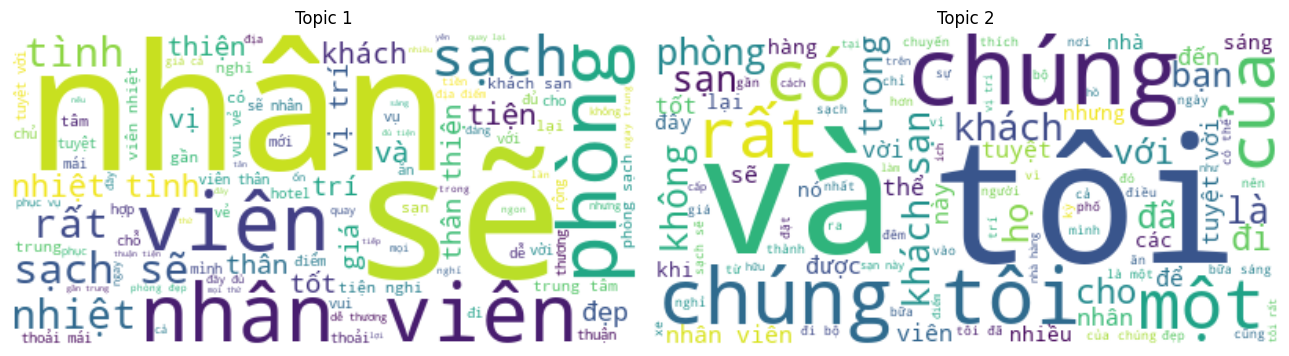

In [139]:
topics_info = topic_model.get_topics()
# print(len(topics_info))
top_6_topics = dict(sorted(topics_info.items(), key=lambda item: len(item[1]), reverse=True)[2:8])
# Prepare topics for visualization
# visual_topics = [(topic_id, words) for topic_id, words in topics_info.items() if topic_id != -1]
visual_topics = [(topic_id, words) for topic_id, words in top_6_topics.items()]
# Visualize topics using word clouds
wordCloud(visual_topics,100)

In [ ]:
topic_model.visualize_barchart(topics = range(2,8))

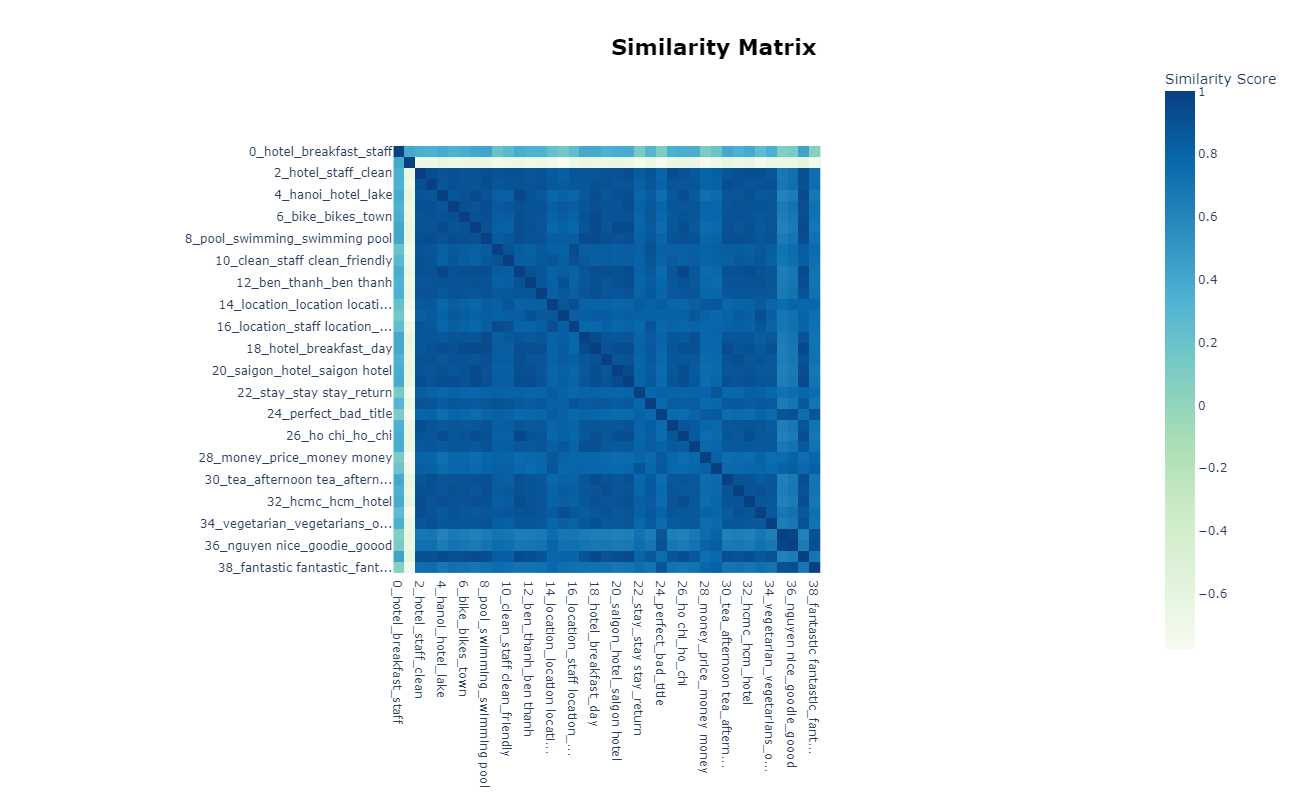

In [73]:
topic_model.visualize_heatmap()


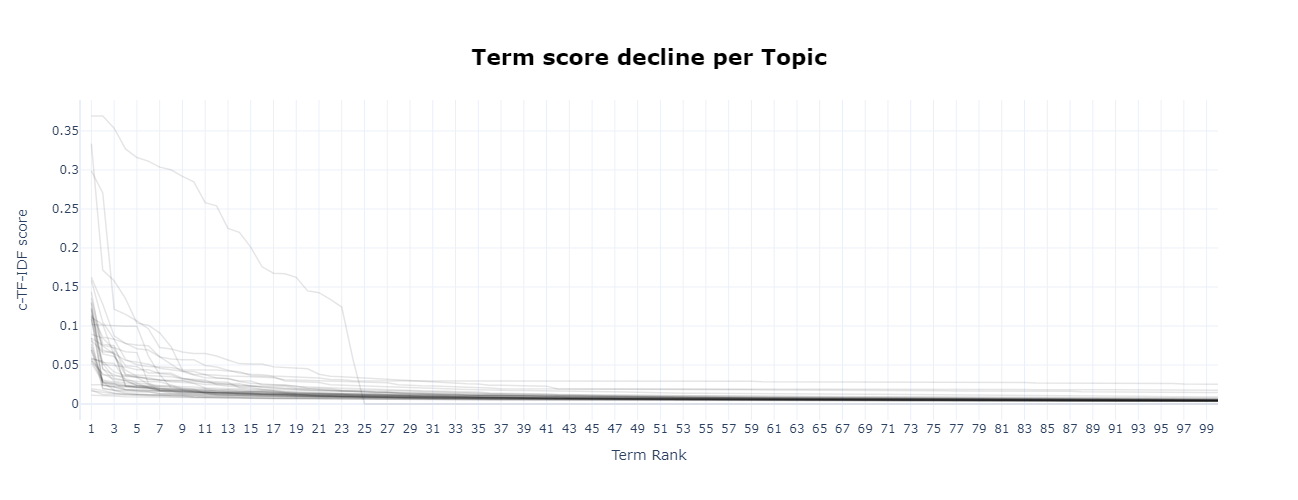

In [77]:
topic_model.visualize_term_rank()


In [67]:
topic_model.visualize_documents(sample, embeddings=enhanced_embeddings)


NameError: name 'enhanced_embeddings' is not defined

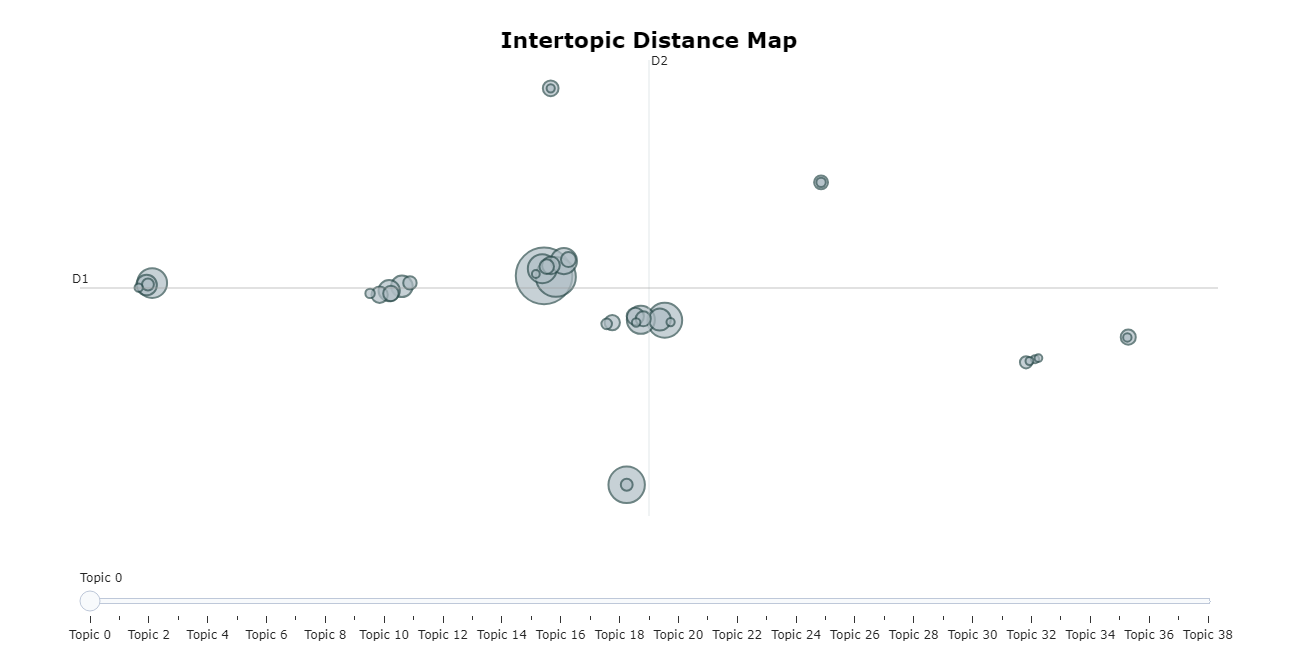

In [83]:
topic_model.visualize_topics(custom_labels=True)

In [39]:
# Next, lets take a look at a speciic abstract ans see how the topic distribution was extracted:
abstract_id=0
print(sample[abstract_id])

Khách sạn này chi thuộc loại 2 sao , quảng cáo 4 sao là không trung thực , không sạch sẽ , nhiều kiến … , với nhan xét của tôi khách sạn này tệ quá


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.26it/s]


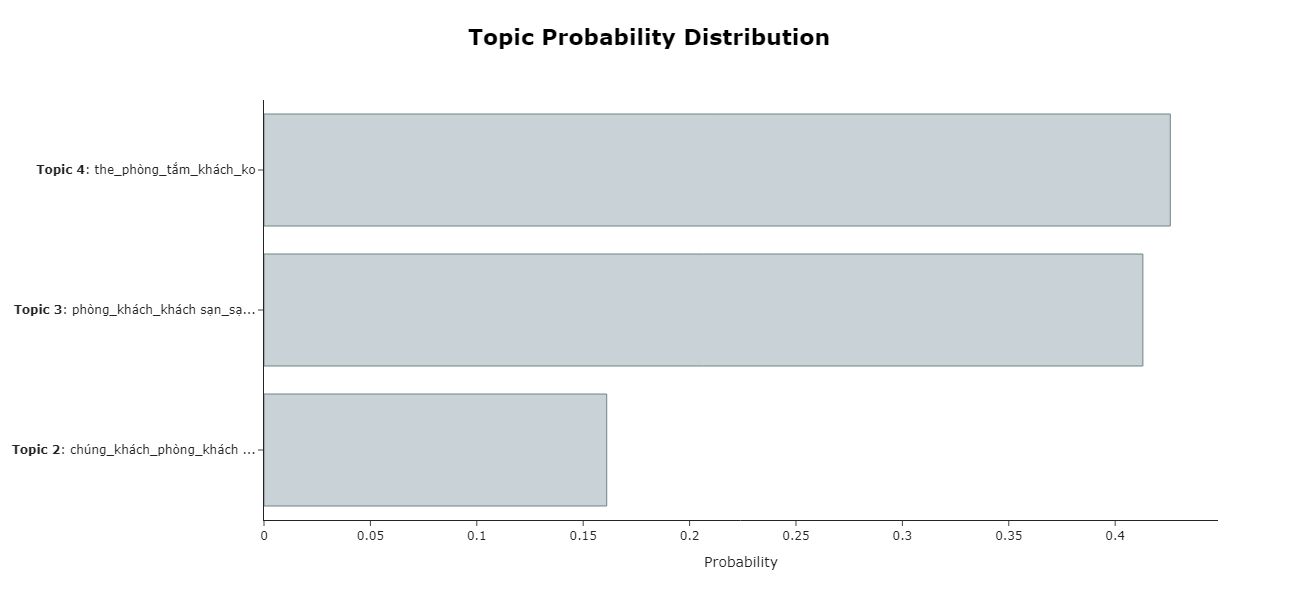

In [42]:
# `topic_distr` contains the distribution of topics in each document
topic_distr, _ =topic_model.approximate_distribution(sample, window=8, stride=4)

topic_model.visualize_distribution(topic_distr[abstract_id])

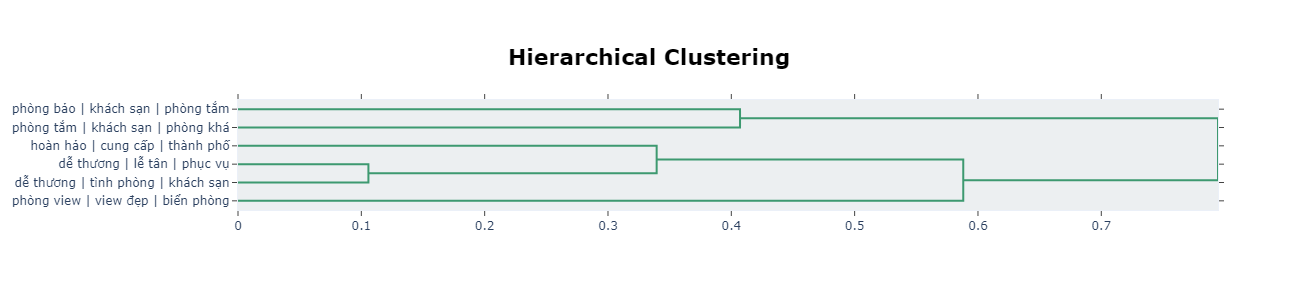

In [43]:
topic_model.visualize_hierarchy(custom_labels=True)

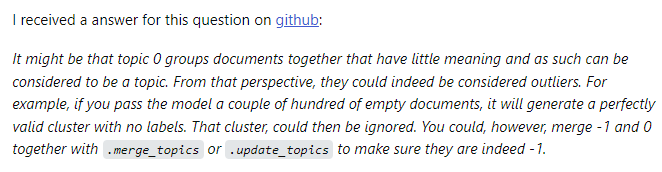

# Coherence Score

In [ ]:
sample = 

In [ ]:
from bertopic import BERTopic
from hdbscan import HDBSCAN

# Define other models and parameters
embedding_model = encoder
umap_model = umap_model
vectorizer_model = vectorizer_model
representation_model = representation_model
top_n_words = 100
verbose = True

# Seed topics
seed_topics = {
    "service": ["dịch vụ",'lễ tân', "nhân viên", "phục vụ", "hỗ trợ", "thân thiện", "chuyên nghiệp", "chăm sóc", "giúp đỡ"],
    "location": ["vị trí", "trung tâm","view", "tiện lợi", "gần", "khu vực", "đi lại", "thuận tiện", "xung quanh"],
    "cleanliness": ["sạch sẽ", "vệ sinh", "dọn dẹp", "sạch", "gọn gàng", "ngăn nắp", "lau chùi", "tươm tất"],
    "room": ["phòng", "tiện nghi", "rộng rãi", "thoải mái", "giường", "trang thiết bị", "điều hòa", "yên tĩnh"],
    "value": ["giá trị", "hợp lý", "chi phí", "đáng tiền", "giá cả", "chất lượng", "kinh tế", "tiết kiệm"]
}

# seed_topics = {
#     "service": ["service", "receptionist", "staff", "service", "support", "friendly", "professional", "care", "help"],
#     "location": ["location", "center", "view", "convenient", "near", "area", "transport", "convenient", "surrounding"],
#     "cleanliness": ["cleanliness", "hygiene", "cleaning", "clean", "tidy", "neat", "wipe", "tidy"],
#     "room": ["room", "facilities", "spacious", "comfortable", "bed", "equipment", "air conditioning", "quiet"],
#     "value": ["value", "reasonable", "cost", "worth", "price", "quality", "economic", "saving"]
# }

# List of min_cluster_size values
min_cluster_sizes = [20, 50, 100, 150, 200]

# Dictionary to store results for each min_cluster_size
results = {}

for min_cluster_size in min_cluster_sizes:
    # Create HDBSCAN model with current min_cluster_size
    hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
    # Create BERTopic model
    topic_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        representation_model=representation_model,
        top_n_words=top_n_words,
        verbose=verbose
    )
    # Fit and transform the sample data
    topics, probs = topic_model.fit_transform(sample, enhanced_embeddings)
    # Store the results
    results[min_cluster_size] = {
        "topics": topics,
        "probs": probs,
        "topic_model": topic_model
    }

# Access the results for each min_cluster_size
for min_cluster_size, result in results.items():
    print(f"Results for min_cluster_size={min_cluster_size}:")
    print("Topics:", result["topics"])
    print("Probs:", result["probs"])
